# Análise de Grãos com OpenCV

Este notebook implementa um pipeline de processamento de imagem para segmentar, contar e analisar grãos (como soja e milho).

## Passos:
1. Carregamento e Visualização da Imagem
2. Pré-processamento (Conversão de cor, Filtros)
3. Segmentação (Limiarização, Watershed)
4. Extração de Características (Contagem, Área)
5. Segmentação com K-Means (Alternativa)
6. Visualização dos Resultados

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuração para exibir imagens inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

def show_image(title, img, cmap=None):
    plt.figure()
    plt.title(title)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        # Converter BGR para RGB para exibição correta no matplotlib
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 1. Carregamento da Imagem

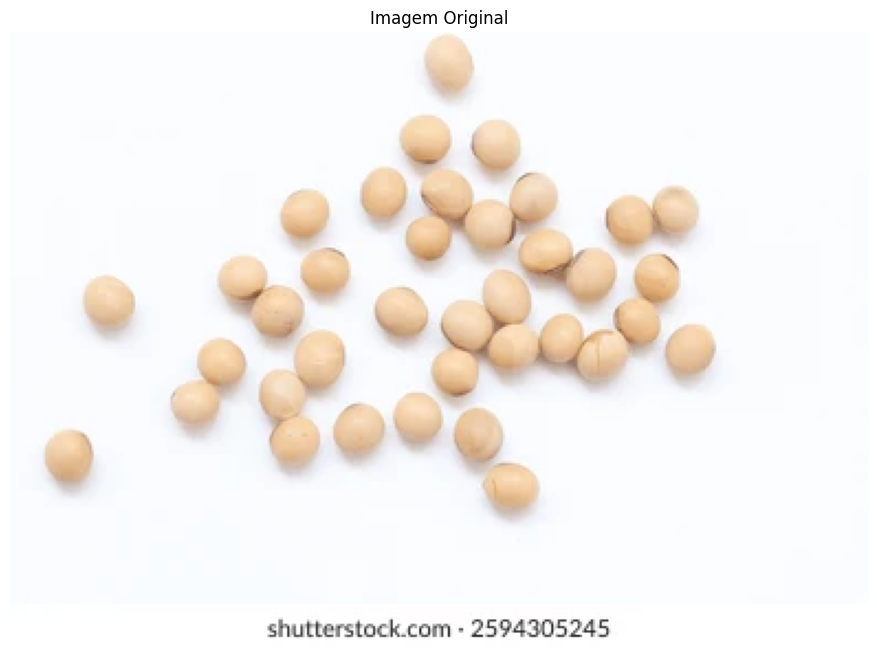

In [9]:
# Caminho da imagem (ajuste conforme necessário)
image_path = Path("../data/imagens/soja-37.jpg")

# Carregar imagem
img = cv2.imread(str(image_path))

if img is None:
    print(f"Erro ao carregar imagem: {image_path}")
else:
    show_image("Imagem Original", img)

## 2. Pré-processamento
Vamos aplicar um desfoque para reduzir ruídos e converter para o espaço de cor HSV, que muitas vezes facilita a separação do objeto do fundo.

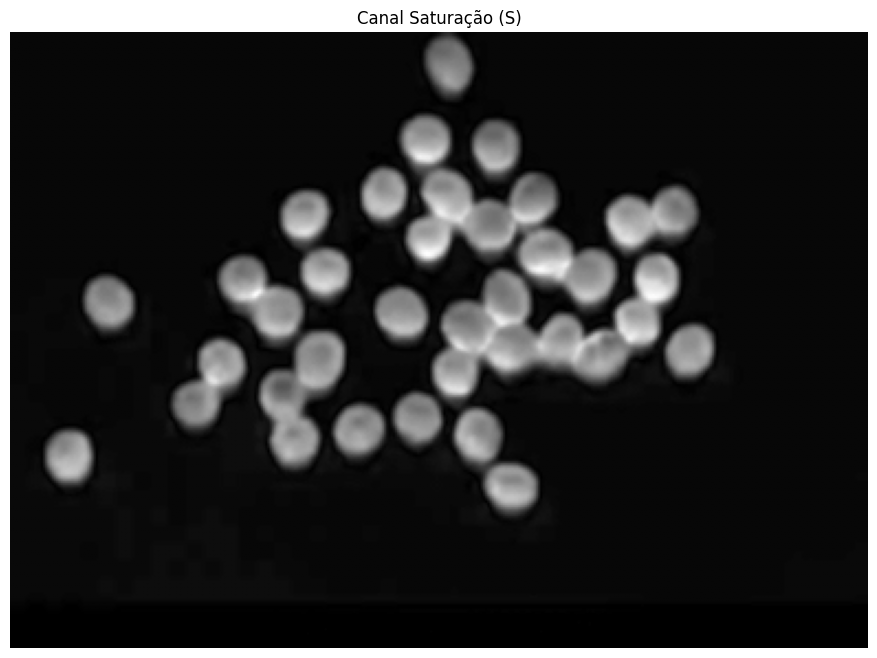

In [10]:
# Reduzir ruído com Gaussian Blur
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Converter para HSV
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# Separar canais para análise
h, s, v = cv2.split(hsv)

show_image("Canal Saturação (S)", s, cmap='gray')

## 3. Segmentação
Usaremos o método de Otsu no canal de Saturação (ou Value, dependendo da imagem) para binarizar a imagem. Em seguida, aplicaremos o algoritmo Watershed para separar grãos que estejam tocando uns nos outros.

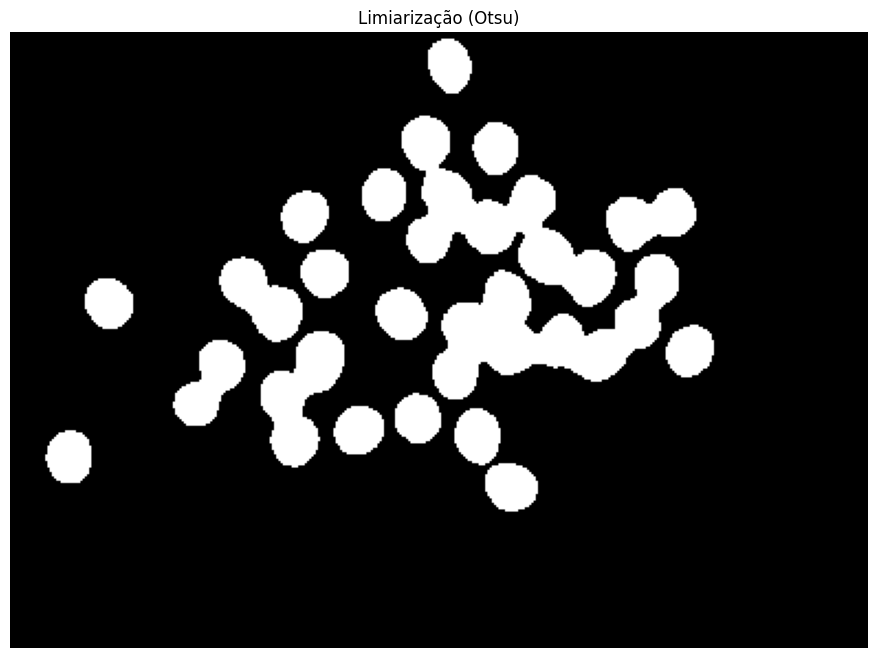

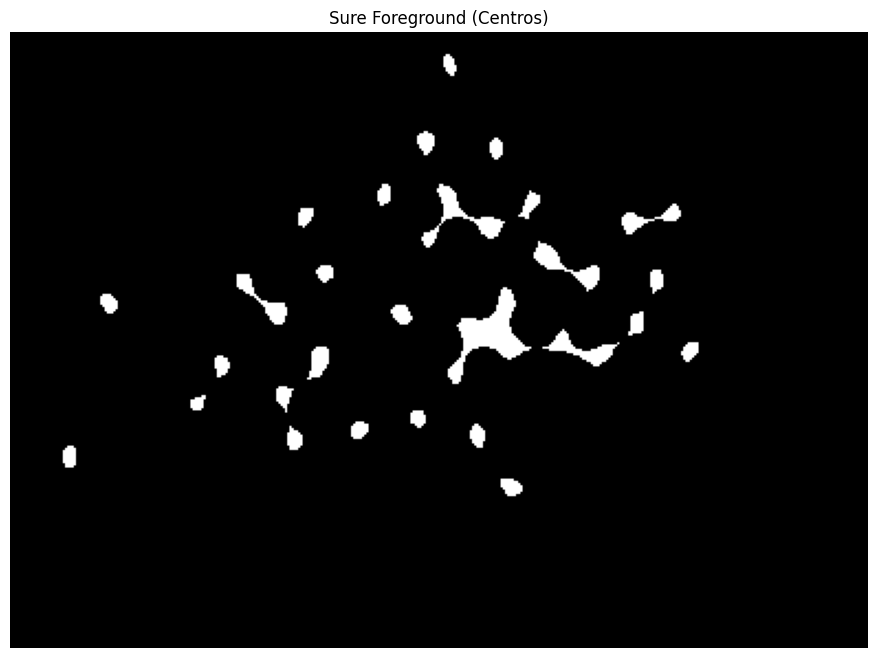

In [11]:
# Limiarização (Otsu)
# Dependendo do fundo, pode ser necessário inverter a máscara (cv2.THRESH_BINARY_INV)
# Aqui assumimos que os grãos têm saturação diferente do fundo
ret, thresh = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Operações morfológicas para remover ruídos e fechar buracos
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Dilatar para ter certeza da área de fundo (Sure Background)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance Transform para encontrar o centro dos grãos (Sure Foreground)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Encontrar região desconhecida (bordas entre grãos)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

show_image("Limiarização (Otsu)", thresh, cmap='gray')
show_image("Sure Foreground (Centros)", sure_fg, cmap='gray')

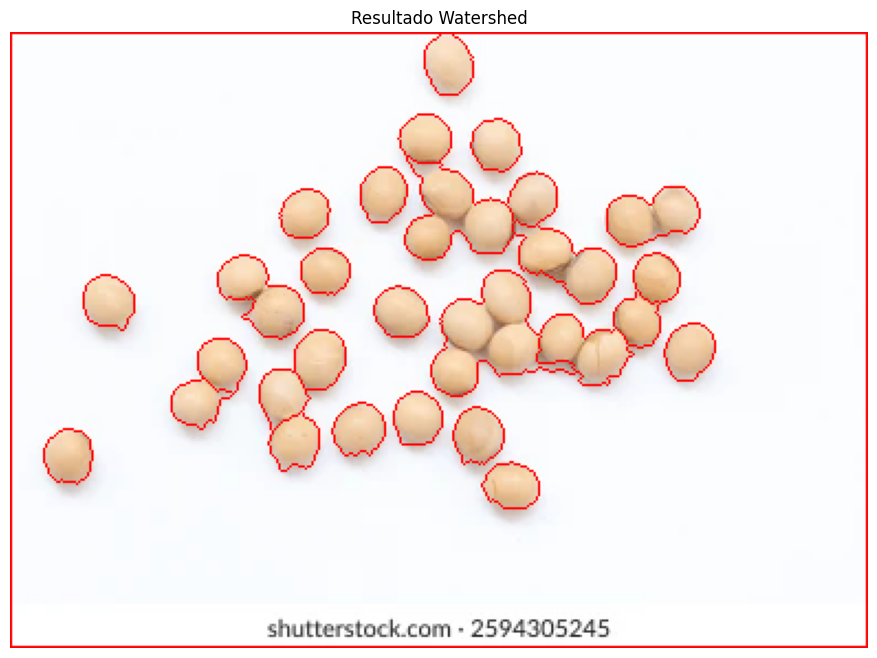

In [12]:
# Marcadores para Watershed
ret, markers = cv2.connectedComponents(sure_fg)

# Adicionar 1 a todos os marcadores para que o fundo seja 1, não 0
markers = markers + 1

# Marcar a região desconhecida com 0
markers[unknown == 255] = 0

# Aplicar Watershed
img_watershed = img.copy()
markers = cv2.watershed(img_watershed, markers)

# Desenhar contornos dos marcadores na imagem (em vermelho)
img_watershed[markers == -1] = [0, 0, 255]

show_image("Resultado Watershed", img_watershed)

## 4. Extração de Características e Análise
Agora vamos iterar sobre os marcadores encontrados para contar os grãos e extrair propriedades como área.

Total de grãos detectados: 28
Área média: 484.29 pixels
Área mínima: 308.0 pixels
Área máxima: 1627.5 pixels


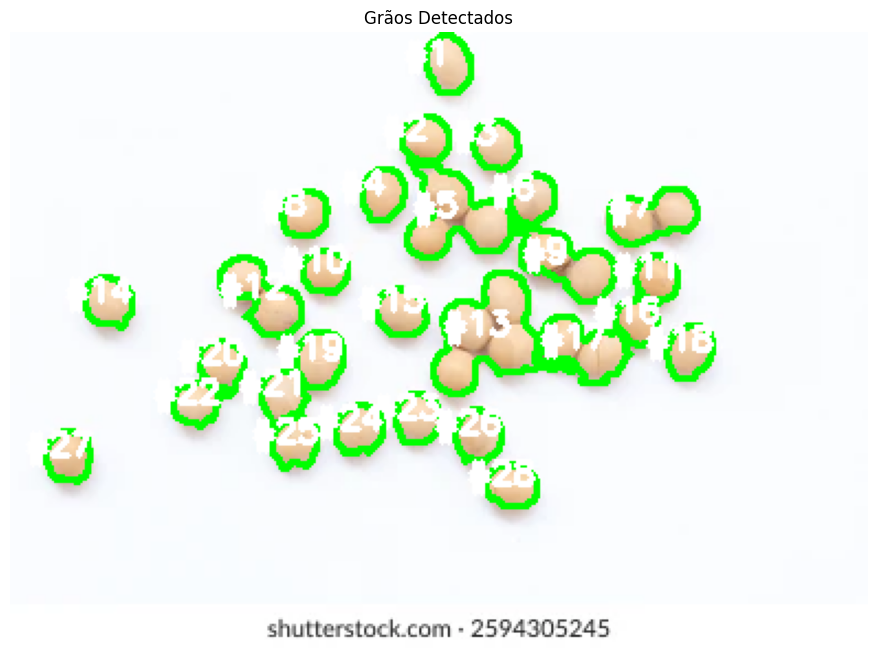

In [13]:
total_grains = 0
grain_areas = []
output_img = img.copy()

# Os marcadores vão de 2 até N (1 é fundo)
for marker_id in np.unique(markers):
    if marker_id <= 1: # Ignorar fundo e bordas (-1)
        continue

    # Criar máscara para o grão atual
    mask = np.zeros_like(s, dtype=np.uint8)
    mask[markers == marker_id] = 255

    # Encontrar contornos na máscara
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        # Filtrar grãos muito pequenos (ruído)
        if area > 100:
            total_grains += 1
            grain_areas.append(area)

            # Desenhar contorno e ID
            cv2.drawContours(output_img, [contour], -1, (0, 255, 0), 2)
            
            # Calcular centroide para colocar o texto
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(output_img, f"#{total_grains}", (cX - 20, cY), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

print(f"Total de grãos detectados: {total_grains}")
if grain_areas:
    print(f"Área média: {np.mean(grain_areas):.2f} pixels")
    print(f"Área mínima: {np.min(grain_areas)} pixels")
    print(f"Área máxima: {np.max(grain_areas)} pixels")

show_image("Grãos Detectados", output_img)

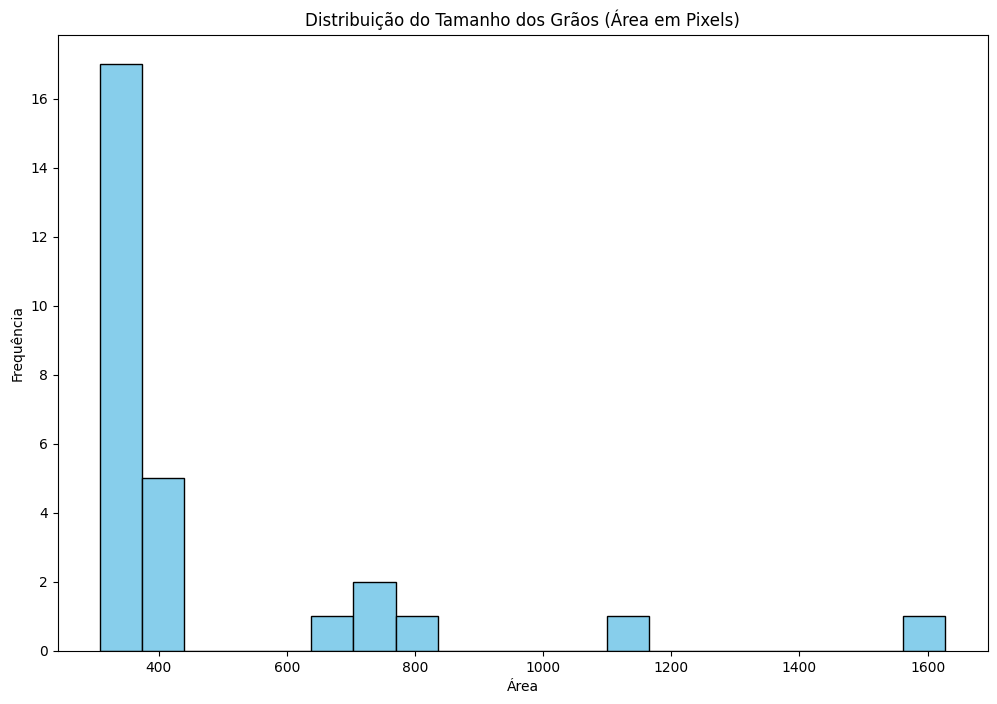

In [14]:
# Histograma de Áreas
if grain_areas:
    plt.figure()
    plt.hist(grain_areas, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribuição do Tamanho dos Grãos (Área em Pixels)")
    plt.xlabel("Área")
    plt.ylabel("Frequência")
    plt.show()

## 5. Segmentação com K-Means (Alternativa)
O K-Means é um algoritmo de aprendizado não supervisionado que pode agrupar pixels baseados em suas cores. Isso pode ser útil quando a limiarização simples não funciona bem.

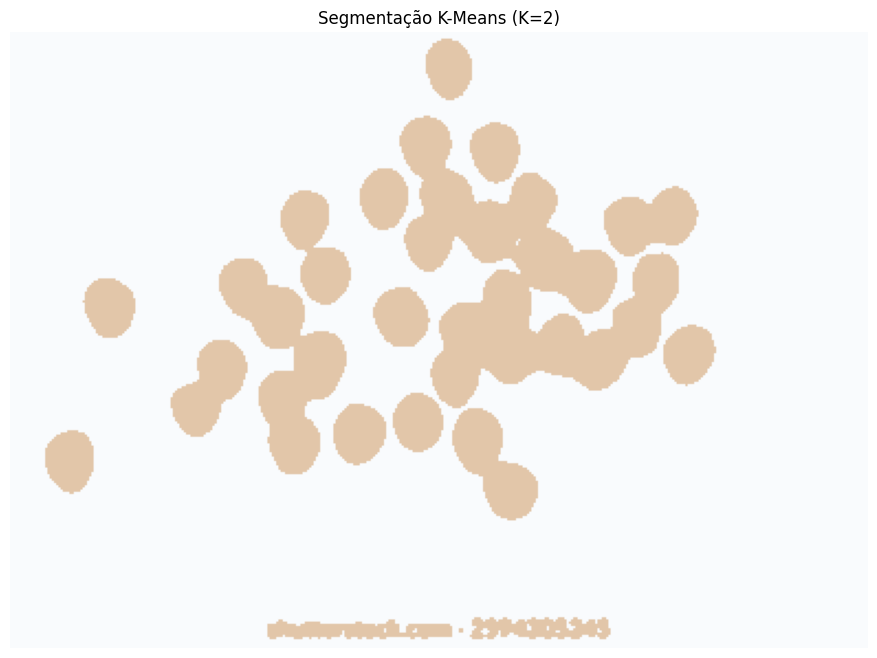

IndexError: boolean index did not match indexed array along axis 0; size of axis is 280 but size of corresponding boolean axis is 109200

In [15]:
# Redimensionar a imagem para uma lista de pixels (altura * largura, 3 canais)
# Usaremos a imagem 'blurred' para reduzir ruído
pixel_values = blurred.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Critérios de parada (interações ou precisão)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# Número de clusters (K)
# K=2: Fundo e Grãos
# K=3: Fundo, Grãos e Sombras/Reflexos (pode ajudar se houver muita variação)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Converter centros de volta para uint8
centers = np.uint8(centers)

# Mapear os labels para os centros (cores)
segmented_data = centers[labels.flatten()]

# Redimensionar de volta para o formato da imagem original
segmented_image = segmented_data.reshape((img.shape))

show_image(f"Segmentação K-Means (K={k})", segmented_image)

# Para visualizar apenas a máscara de um dos clusters (tentar isolar os grãos)
# Assumindo que os grãos são a cor mais clara ou mais escura, podemos tentar visualizar as máscaras
for i in range(k):
    mask_kmeans = np.zeros_like(img)
    mask_kmeans[labels.flatten() == i] = [255, 255, 255]
    mask_kmeans = mask_kmeans.reshape((img.shape))
    show_image(f"Cluster {i}", mask_kmeans, cmap='gray')